In [3]:
# Import the primary data analysis libraries
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
import math
from scipy import signal
import pandas as pd
import os
log_path = 'data/Pocket/Orientation1/'

In [4]:
#helper fundtion
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))



## Experiment 1
Keep the phone in a fixed orientation in a fixed location the body (you can also hold it steady). Walk and count number of steps. The student should confirm the number of walked steps. 

### Baseline: Windowed Peak Detection

784
True Number of Steps = 10. Detected Number of Steps = 10
839
True Number of Steps = 12. Detected Number of Steps = 13
975
True Number of Steps = 15. Detected Number of Steps = 16
975
True Number of Steps = 15. Detected Number of Steps = 16
975
True Number of Steps = 15. Detected Number of Steps = 16
1101
True Number of Steps = 20. Detected Number of Steps = 21
1193
True Number of Steps = 25. Detected Number of Steps = 25
1276
True Number of Steps = 30. Detected Number of Steps = 26
Mean Absolute Error = 1.125
Mean Percentage Error = 2.50%


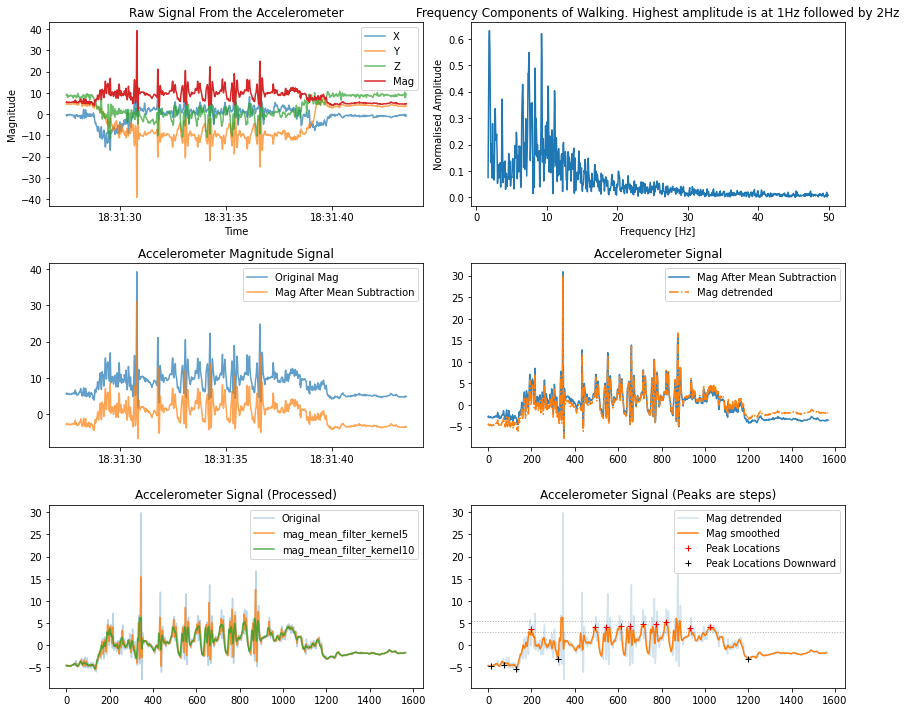

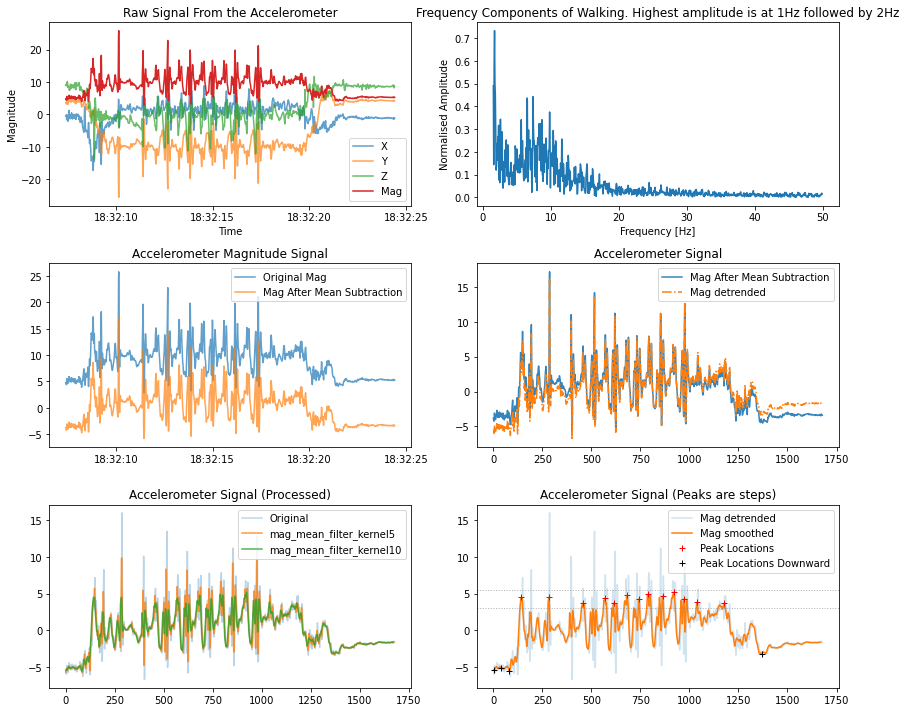

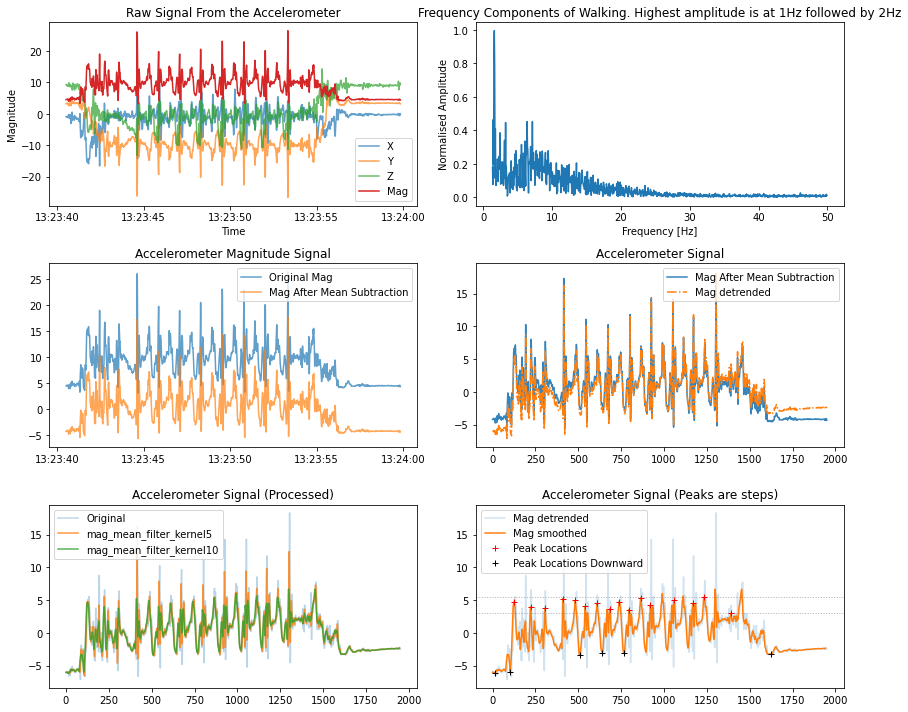

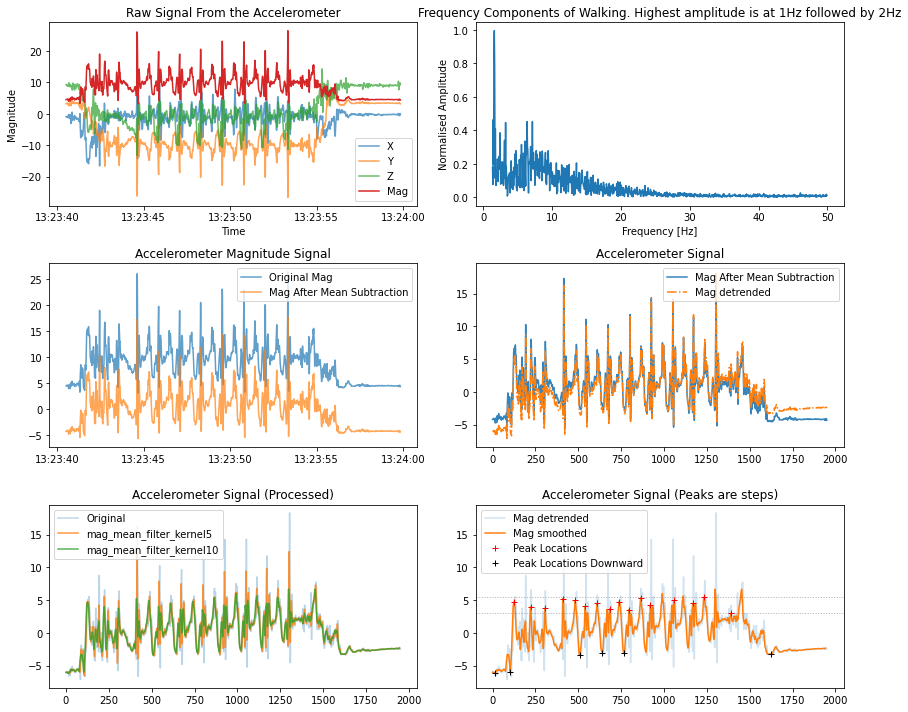

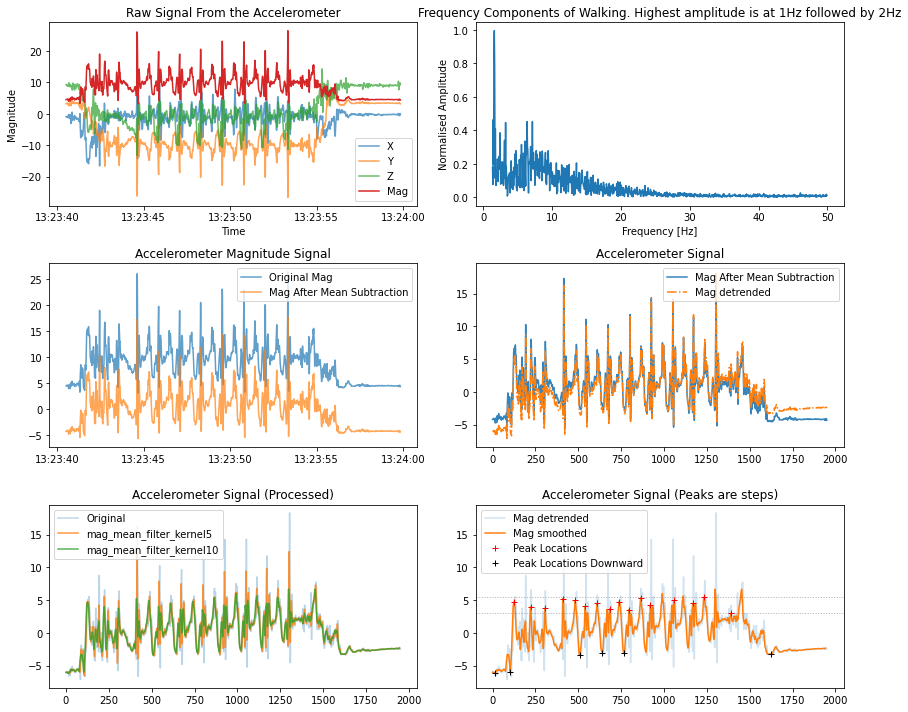

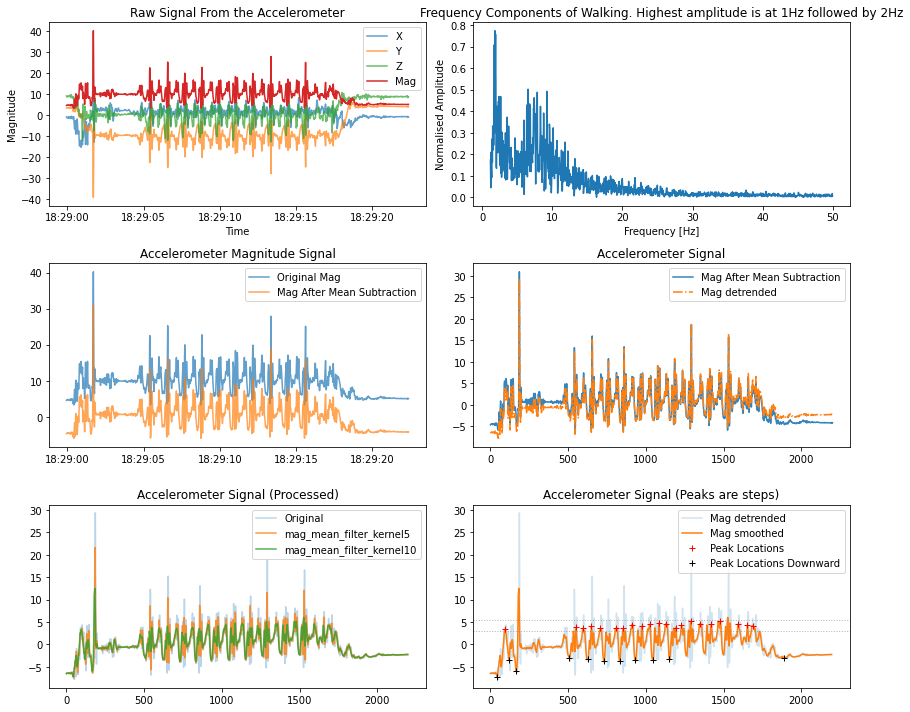

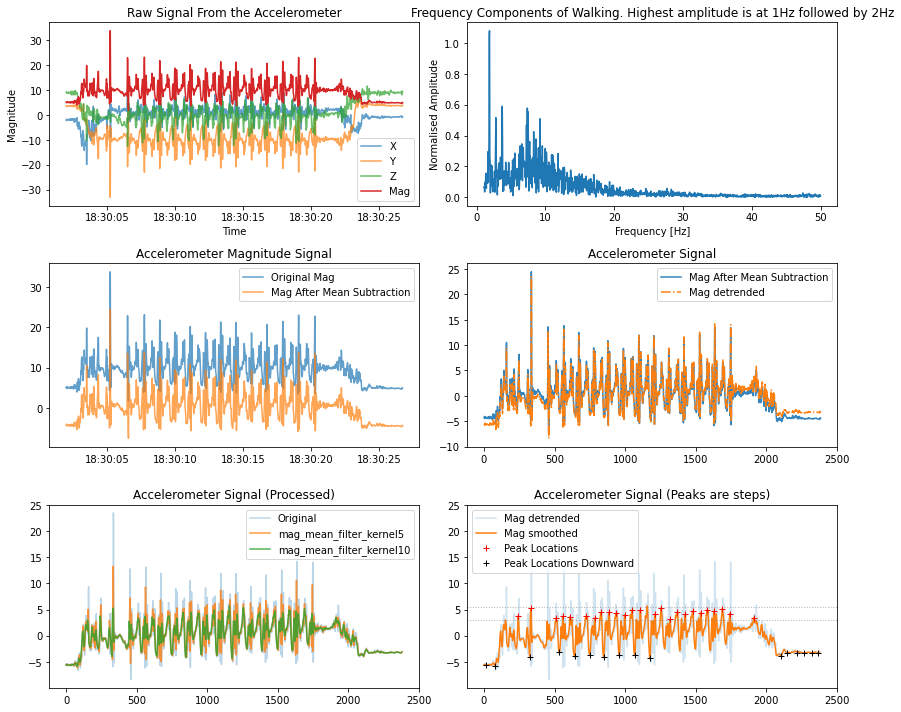

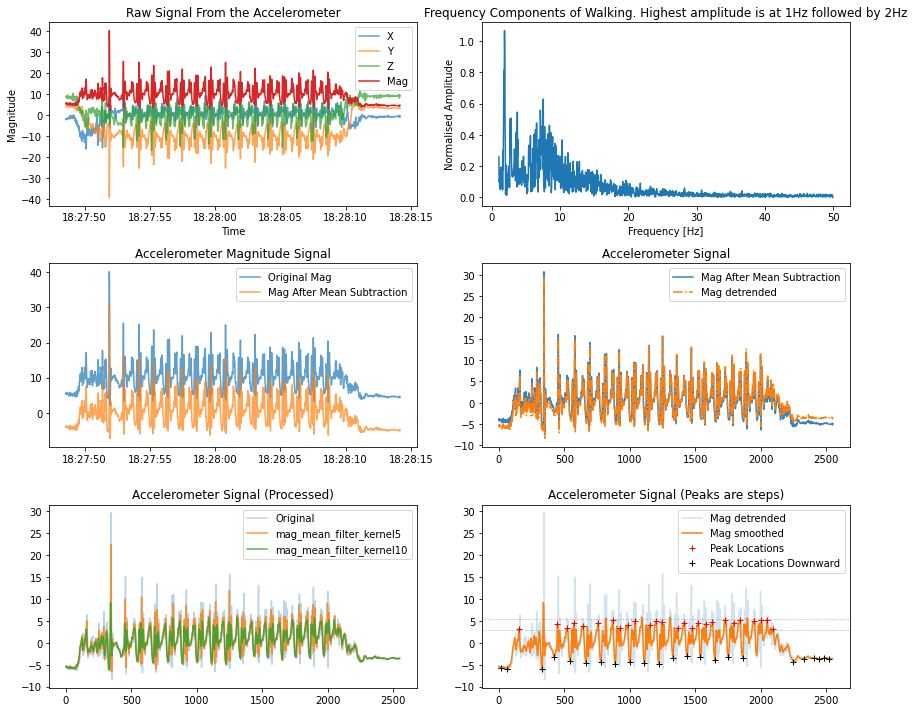

In [30]:
detailedOutput = False;
difference = 0 #this variable will be used to track the Mean Absolute Error.
mpe = 0 #this variable will track the mean percentage error
for filename in os.listdir(log_path):
    #each file contains the step count in the first two characters
    groundTruth = int(filename[:2])
    df1 = pd.read_csv(log_path+'/'+filename).dropna()
    df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
    df1.index = df1.Timestamp;

    fig, ax = plt.subplots(3,2, figsize=(12,10))
    ax[0,0].plot(df1.Timestamp, df1.X, alpha=0.7)
    ax[0,0].plot(df1.Timestamp, df1.Y, alpha=0.7)
    ax[0,0].plot(df1.Timestamp, df1.Z, alpha=0.7)
    ax[0,0].plot(df1.Timestamp, np.sqrt(df1.X**2+df1.Y**2+df1.Z))
    ax[0,0].set_title('Raw Signal From the Accelerometer')
    ax[0,0].legend(['X', 'Y', 'Z', 'Mag'])
    ax[0,0].set_xlabel('Time')
    ax[0,0].set_ylabel('Magnitude')


    acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
    #find FFT of the signal
    fs, hs =compute_fft(acc1_mag, 100, n = None, scale_amplitudes = True)
    print(len(fs))
    ax[0,1].plot(fs[26:],hs[26:])
    ax[0,1].set_xlabel('Frequency [Hz]')
    ax[0,1].set_ylabel('Normalised Amplitude')
    ax[0,1].set_title('Frequency Components of Walking. Highest amplitude is at 1Hz followed by 2Hz');
    
    
    if detailedOutput == True:
        print("**Statistics of the accelerometer signal**")
    sample_time_in_s = df1.Timestamp.iloc[-1] - df1.Timestamp.iloc[0]
    if detailedOutput == True:
        print("Length (raw diff): {} secs".format(sample_time_in_s.seconds))
        print("Avg x: {:.2f} (SD={:.2f})".format(np.mean(df1.X), np.std(df1.X)))
        print("Avg y: {:.2f} (SD={:.2f})".format(np.mean(df1.Y), np.std(df1.Y)))
        print("Avg z: {:.2f} (SD={:.2f})".format(np.mean(df1.Z), np.std(df1.Z)))
        print("Avg mag: {:.2f} (SD={:.2f})\n".format(np.mean(acc1_mag), np.std(acc1_mag)))
    #Derive sampling rate for TYPE 1
    map_sec_to_sample_count = dict()
    for timestamp_ms in df1.Timestamp:
        sec_floor = timestamp_ms.second
        if sec_floor not in map_sec_to_sample_count:
            map_sec_to_sample_count[sec_floor] = 0
        map_sec_to_sample_count[sec_floor] = map_sec_to_sample_count[sec_floor] + 1

    if detailedOutput == True:
        print("Length (raw diff): {} secs".format(sample_time_in_s.seconds))
        print("Length (rounded ceiling): {} secs".format(len(map_sec_to_sample_count)))
    counts = list(map_sec_to_sample_count.values())
    np_counts = np.array(counts)
    sampling_rate_imprecise = df1.Timestamp.size / sample_time_in_s.seconds
    if detailedOutput == True:
        print("Coarse sampling rate: {:.2f} samples/sec".format(sampling_rate_imprecise))
    sampling_rate = np.average(np_counts)
    if detailedOutput == True:
        print("Coarse sampling rate: {:.2f} samples/sec".format(sampling_rate_imprecise))
        print("More precise sampling rate calc: {:.2f} samples/sec (SD={:.2f} samples/sec)".format(sampling_rate, np.std(np_counts)))

    #Here, we'll subtract out the mean so that the average of the signal is 0
    #useful to count ZCR
    mag_after_mean_subtraction = acc1_mag - np.average(acc1_mag)
    if detailedOutput == True:
        print("Average of the signal [Before] = {}".format(np.average(acc1_mag)))
        print("Average of the signal [After] = {}".format(np.average(mag_after_mean_subtraction)))
    ax[1,0].plot(acc1_mag, alpha=0.7, label="Original Mag")
    ax[1,0].plot(mag_after_mean_subtraction, alpha=0.7, label="Mag After Mean Subtraction")
    ax[1,0].set_title("Accelerometer Magnitude Signal")
    ax[1,0].legend();

    # We can also use scipy's built in detrend algorithm, which is the result
    # of a linear least-squares fit to the data
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
    mag_detrended = sp.signal.detrend(acc1_mag) 
    ax[1,1].plot(mag_after_mean_subtraction.values, alpha=0.9, label="Mag After Mean Subtraction")
    ax[1,1].plot(mag_detrended, alpha=1, linestyle="-.", label="Mag detrended")
    ax[1,1].set_title("Accelerometer Signal")
    ax[1,1].legend()

    # Here are different mean smoothing filters
    # Note that the filter window size should really be a function of your sampling rate
    # Now, let's play around with various smoothing methods
    # Here are different mean smoothing filters
    # Note that the filter window size should really be a function of your sampling rate
    filter_window_size = 5
    # Convolve using a mean filter
    # https://numpy.org/doc/stable/reference/generated/numpy.convolve.html?highlight=convolve#numpy.convolve
    mag_mean_filter_kernel5 = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')
    filter_window_size = 10
    mag_mean_filter_kernel10 = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')
    ax[2,0].plot(mag_detrended, alpha=0.3, label="Original")
    ax[2,0].plot(mag_mean_filter_kernel5, alpha=0.8, label="mag_mean_filter_kernel5")
    ax[2,0].plot(mag_mean_filter_kernel10, alpha=0.8, label="mag_mean_filter_kernel10")
    ax[2,0].set_title("Accelerometer Signal (Processed)")
    ax[2,0].legend()



    # Now, basic algorithm to infer steps
    filter_window_size = math.ceil(sampling_rate * 0.1)

    # Convolve using a mean filter
    # https://numpy.org/doc/stable/reference/generated/numpy.convolve.html?highlight=convolve#numpy.convolve
    mag_filtered = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')
    ax[2,1].plot(mag_detrended, alpha=0.2, label="Mag detrended")
    ax[2,1].plot(mag_filtered, alpha=1, label="Mag smoothed")
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
    # assume stride cadence threshold of ~100 steps/min, which is 1.6 steps/sec
    # but let's round it up to ~2 steps/sec (so, 2 Hz)
    # so, once we find a peak, we should wait ~0.5 seconds, which we translate into num of samples
    min_distance_between_peaks = 0.4 * sampling_rate # distance between peaks in samples
    min_peak_height = 3
    max_peak_height = 5.5

    
    peak_indices, peak_properties = sp.signal.find_peaks(mag_filtered, height=min_peak_height, distance=min_distance_between_peaks)
    peak_indices_i, peak_properties_i = sp.signal.find_peaks(-mag_filtered, height=min_peak_height, distance=min_distance_between_peaks)

    if detailedOutput == True:
        print("Min num samples between peaks:", min_distance_between_peaks)
        print("We've detected:", len(peak_indices), "initial peaks")
        print("Average peak:", np.average(mag_filtered[peak_indices]), "SD=", np.std(mag_filtered[peak_indices]))
        print("Min peak:", np.min(mag_filtered[peak_indices]))
        print("Max peak:", np.max(mag_filtered[peak_indices]))
        print();
        print("We've detected:", len(peak_indices_i), "initial peaks in the inverted signal")
        print("Average peak:", np.average(mag_filtered[peak_indices_i]), "SD=", np.std(mag_filtered[peak_indices_i]))
        print("Min peak:", np.min(mag_filtered[peak_indices_i]))
        print("Max peak:", np.max(mag_filtered[peak_indices_i]))
        print("Filtering out peaks that exceed our maximum:")

    # filter out peaks that exceed our maximum
    filtered_peak_indices = []
    for peak_index in peak_indices:
        if(mag_filtered[peak_index] <= max_peak_height):
            filtered_peak_indices.append(peak_index)

    filtered_peak_indices_i = []
    for peak_index in peak_indices_i:
        if(mag_filtered[peak_index] <= max_peak_height):
            filtered_peak_indices_i.append(peak_index)

    peak_indices = list(filtered_peak_indices)
    peak_indices_i = list(filtered_peak_indices_i)
    
    if detailedOutput == True:
        print("***Now, we've detected:", len(peak_indices), " peaks***")
        print("Average peak:", np.average(mag_filtered[peak_indices]), "SD=", np.std(mag_filtered[peak_indices]))
        print("Min peak:", np.min(mag_filtered[peak_indices]))
        print("Max peak:", np.max(mag_filtered[peak_indices]))
        print("Now, we've detected:", len(peak_indices_i), " peaks")
        print("Average peak:", np.average(mag_filtered[peak_indices_i]), "SD=", np.std(mag_filtered[peak_indices_i]))
        print("Min peak:", np.min(mag_filtered[peak_indices_i]))
        print("Max peak:", np.max(mag_filtered[peak_indices_i]))

    # Plots the peaks
    ax[2,1].axhline(y=min_peak_height, linewidth=1, linestyle=":", alpha=0.6, color='gray')
    ax[2,1].axhline(y=max_peak_height, linewidth=1, linestyle=":", alpha=0.6, color='gray')
    ax[2,1].plot(peak_indices, mag_filtered[peak_indices], 'y+', color="red", label="Peak Locations")
    ax[2,1].plot(peak_indices_i, mag_filtered[peak_indices_i], 'y+', color="black", label="Peak Locations Downward")

    ax[2,1].set_title("Accelerometer Signal (Peaks are steps)")
    ax[2,1].legend()
    fig.tight_layout()
    print("True Number of Steps = {}. Detected Number of Steps = {}".format(groundTruth,len(peak_indices)))
    #compute error
    difference+=(abs(groundTruth-len(peak_indices)))
    mpe+=((groundTruth-len(peak_indices))/groundTruth)
print("Mean Absolute Error = {}".format(difference/len(os.listdir(log_path))))
mpe = abs((mpe/len((os.listdir(log_path)))*100));
print("Mean Percentage Error = {:.2f}%".format(mpe))

### Adaptive Peak Detection Algorithm
The code below find the optimal set of hyperparametrs for which the error is lowest. We then use the same set to deduce the step counts

In [64]:
# Settings: lag = 30, threshold = 5, influence = 0
lag = [i for i in range(10,500)]
threshold = [i for i in range(0,100)]
influence = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
mpe_old = 99 #this variable will track the mean percentage error
mpe = 0;

optimalLag = []
optimalThreshold = []
optimalInfluence = []
mpe_list = []

#set your error threshold here. We will be happy if the error threshold beats the baseline performence
Errorthreshold = 6.

#change directory here to find the optimal parameters based on location of the body
log_path = 'data/Hand/'

def work(lag, threshold, influence):
    mpe_old = 99;
    for l in lag:
        for th in threshold:
            for inf in influence:
                mpe=0;
                for filename in os.listdir(log_path):
                    #fig, ax  = plt.subplots(2,1)
                    #each file contains the step count in the first two characters
                    groundTruth = int(filename[:2])
                    df1 = pd.read_csv(log_path+'/'+filename).dropna()
                    df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
                    df1.index = df1.Timestamp;
                    acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
                    # Run algo with settings from above
                    result = thresholding_algo(acc1_mag, lag=l, threshold=th, influence=inf)

                    #ax[0].plot(np.arange(1, len(acc1_mag)+1), acc1_mag)
                    #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"], color="cyan", lw=2)
                    #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)
                    #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)
                    #ax[1].plot(np.arange(1, len(acc1_mag)+1), result["signals"], color="red", lw=2)
                    #print("\nSteps Detected = {}".format(len([i for i in result["signals"] if i == 1.0])))
                    #print("Ground Truth = {}".format(groundTruth))
                    mpe+=((groundTruth-len([i for i in result["signals"] if i == 1.0]))/groundTruth)

                mpe = abs((mpe/len((os.listdir(log_path)))*100));
                #print(mpe)
                if mpe < mpe_old:
                    mpe_old = mpe
                    print("Mean Percentage Error = {:.2f}%".format(mpe_old))
                    #save the param
                    mpe_list.append(mpe_old)
                    optimalInfluence.append(inf)
                    optimalLag.append(l)
                    optimalThreshold.append(th)
                    if mpe_old <= Errorthreshold:
                        print("Optimal value of lag = {}, threshold = {} and influence = {}".format(l,th,inf))
                        return;

In [65]:
work(lag, threshold, influence)

Mean Percentage Error = 82.54%
Mean Percentage Error = 57.78%
Mean Percentage Error = 41.43%
Mean Percentage Error = 27.94%
Mean Percentage Error = 2.67%
Optimal value of lag = 10, threshold = 5 and influence = 0.4



Steps Detected = 15
Ground Truth = 10

Steps Detected = 12
Ground Truth = 12

Steps Detected = 13
Ground Truth = 15

Steps Detected = 13
Ground Truth = 15

Steps Detected = 13
Ground Truth = 15

Steps Detected = 21
Ground Truth = 20

Steps Detected = 26
Ground Truth = 25

Steps Detected = 26
Ground Truth = 30
Mean Percentage Error = 0.71%


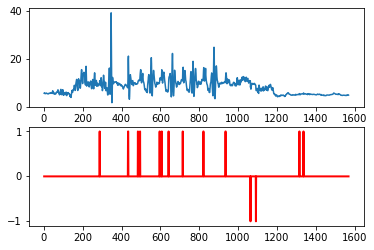

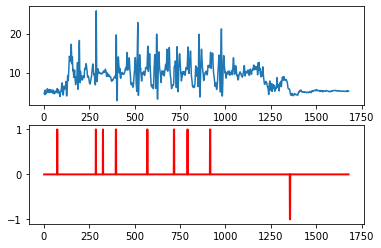

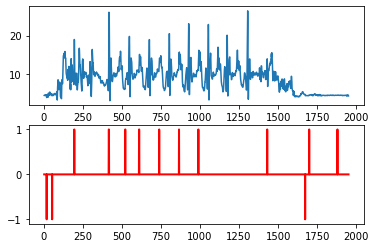

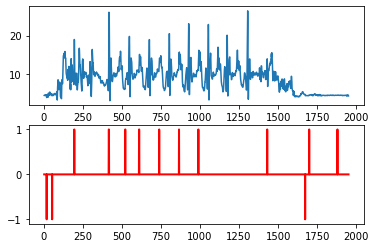

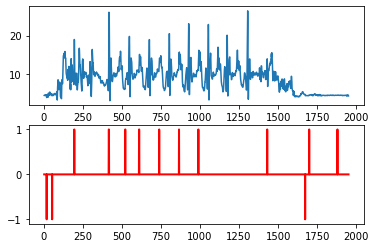

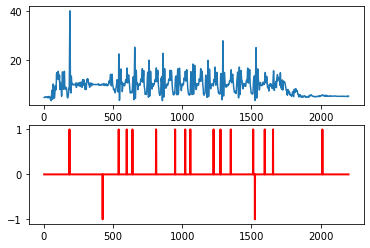

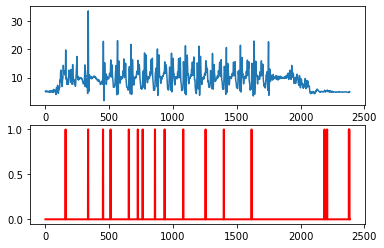

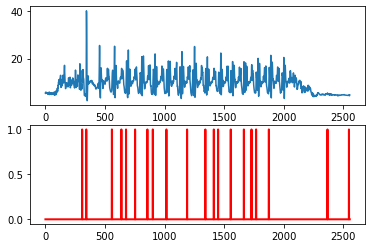

In [55]:
mpe=0;

#use optimal values detected above

for filename in os.listdir(log_path):
    fig, ax  = plt.subplots(2,1)
    #each file contains the step count in the first two characters
    groundTruth = int(filename[:2])
    df1 = pd.read_csv(log_path+'/'+filename).dropna()
    df1['Timestamp'] = pd.to_datetime(df1.Timestamp, format='%d-%b-%Y %H:%M:%S.%f')
    df1.index = df1.Timestamp;
    acc1_mag = np.sqrt(df1.X**2+df1.Y**2+df1.Z)
    # Run algo with settings from above
    result = thresholding_algo(acc1_mag, lag=optimalLag[-1], threshold=optimalThreshold[-1], influence=optimalInfluence[-1])

    ax[0].plot(np.arange(1, len(acc1_mag)+1), acc1_mag)
    #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"], color="cyan", lw=2)
    #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)
    #ax[0].plot(np.arange(1, len(acc1_mag)+1),result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)
    ax[1].plot(np.arange(1, len(acc1_mag)+1), result["signals"], color="red", lw=2)
    print("\nSteps Detected = {}".format(len([i for i in result["signals"] if i == 1.0])))
    print("Ground Truth = {}".format(groundTruth))
    mpe+=((groundTruth-len([i for i in result["signals"] if i == 1.0]))/groundTruth)

mpe = abs((mpe/len((os.listdir(log_path)))*100));
print("Mean Percentage Error = {:.2f}%".format(mpe))